# Decision Tree model

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, recall_score
from sklearn.tree import DecisionTreeClassifier
import os.path

if os.path.isfile("random_state.txt"):
    with open("random_state.txt", "r") as f:
        random_state = int(f.read())
        print(f"Using random state {random_state}")

    np.random.seed(random_state)

from utilities import *

test_size = 0.2

Using random state 69420


In [2]:
data = pd.read_csv('data/train_processed.csv')
target = "Machine failure"

In [3]:
X = data.drop(columns=[target], axis=1)
y = data[target]

In [4]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=random_state)

print(f"Train size: {len(Xtr)}")
print(f"Test size: {len(Xte)}")

Train size: 108891
Test size: 27223


### Baseline

In [5]:
base_dt = DecisionTreeClassifier(random_state=random_state)
base_dt.fit(Xtr, ytr);

In [6]:
y_pred = base_dt.predict(Xte)
print(classification_report(yte, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26841
           1       0.31      0.38      0.34       382

    accuracy                           0.98     27223
   macro avg       0.65      0.68      0.66     27223
weighted avg       0.98      0.98      0.98     27223



In [7]:
print("Feature importances:")
for i, imp in enumerate(base_dt.feature_importances_):
    print(f"\t{X.columns[i]}: {imp:.3f}")

Feature importances:
	id: 0.188
	Air temperature [K]: 0.150
	Process temperature [K]: 0.121
	Rotational speed [rpm]: 0.162
	Torque [Nm]: 0.231
	Tool wear [min]: 0.149


In [8]:
base_depth = base_dt.get_depth()
print(f"Tree depth: {base_depth}")

Tree depth: 34


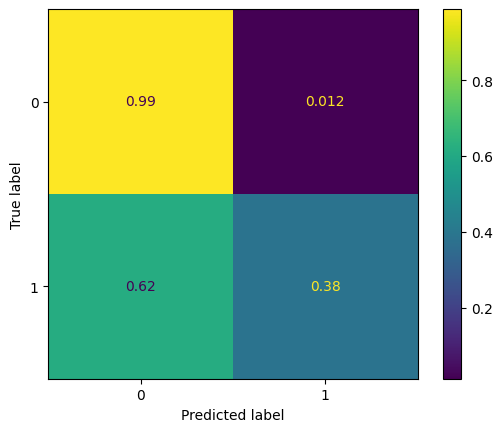

In [9]:
ConfusionMatrixDisplay.from_estimator(base_dt, Xte, yte, display_labels=base_dt.classes_, normalize="true");

### Grid search #1

In [ ]:
# Set the parameters by cross-validation
params1 = [{'max_depth': [*range(4,base_depth+1)],
           'criterion' : ['entropy', 'gini'],
           "class_weight": [None, "balanced"]
           }]

scores1 = [
          'accuracy',
          'precision_macro',
          'recall_macro',
          'f1_macro'
          ]

results1 = grid_search(params1, scores1, base_dt, Xtr, ytr, Xte, yte)

--------------------
Score: accuracy
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26841
           1       0.53      0.33      0.41       382

    accuracy                           0.99     27223
   macro avg       0.76      0.66      0.70     27223
weighted avg       0.98      0.99      0.98     27223

Best parameters:
	ccp_alpha: 0.0
	class_weight: None
	criterion: entropy
	max_depth: 7
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	monotonic_cst: None
	random_state: 69420
	splitter: best

Feature importances:
	id: 0.015
	Air temperature [K]: 0.144
	Process temperature [K]: 0.050
	Rotational speed [rpm]: 0.378
	Torque [Nm]: 0.267
	Tool wear [min]: 0.146
--------------------
Score: precision_macro
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00 

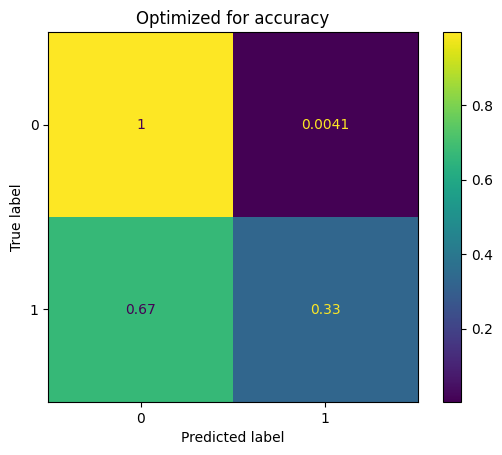

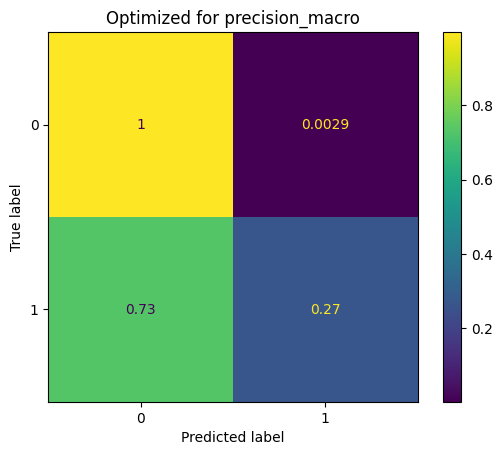

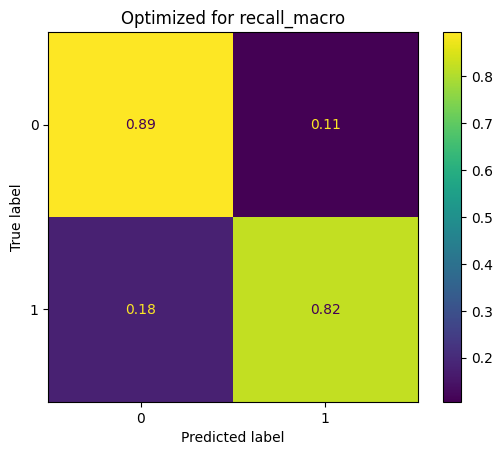

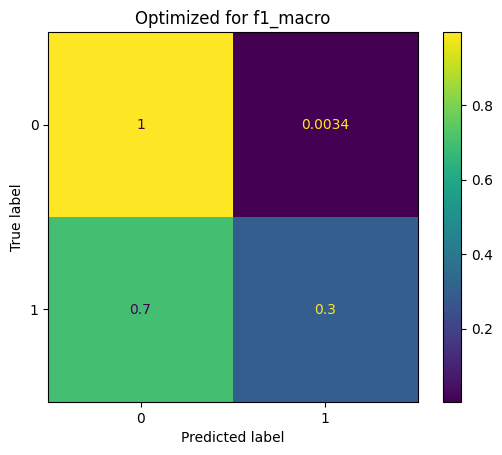

In [14]:
print_gridsearch_results(results1, X.columns)

From the confusion matrices, we see that the best model is the one optimizing the "recall_macro" metric, which, for the optimized parameters, uses:

- `max_depth` : 4
- `criterion` : `gini`
- `class_weight` : `balanced`

### Grid search #2

The previous best model had, however, a lower accuracy (89%) compared to the base model (97.8%) - which in turn had a significantly lower recall macro average of 68%. We use a custom scoring function to find the Decision Tree model that optimizes the recall macro while keeping accuracy at least at 90%

In [15]:
accu_recall = make_scorer(accu_recall_scorer, min_accuracy=0.9)

In [16]:
# Set the parameters by cross-validation
params2 = [{'max_depth': [*range(4,base_depth+1)],
           'criterion' : ['gini'],
           "class_weight": ["balanced"]
           }]

scores2 = [accu_recall]

results2 = grid_search(params2, scores2, base_dt, Xtr, ytr, Xte, yte)

Tuning hyperparameters for: make_scorer(accu_recall_scorer, response_method='predict', min_accuracy=0.9)...done


--------------------
Score: make_scorer(accu_recall_scorer, response_method='predict', min_accuracy=0.9)
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     26841
           1       0.12      0.81      0.21       382

    accuracy                           0.92     27223
   macro avg       0.56      0.86      0.58     27223
weighted avg       0.98      0.92      0.94     27223

Best parameters:
	ccp_alpha: 0.0
	class_weight: balanced
	criterion: gini
	max_depth: 5
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	monotonic_cst: None
	random_state: 69420
	splitter: best

Feature importances:
	id: 0.000
	Air temperature [K]: 0.027
	Process temperature [K]: 0.001
	Rotational speed [rpm]: 0.618
	Torque [Nm]: 0.160
	Tool wear [min]: 0.192


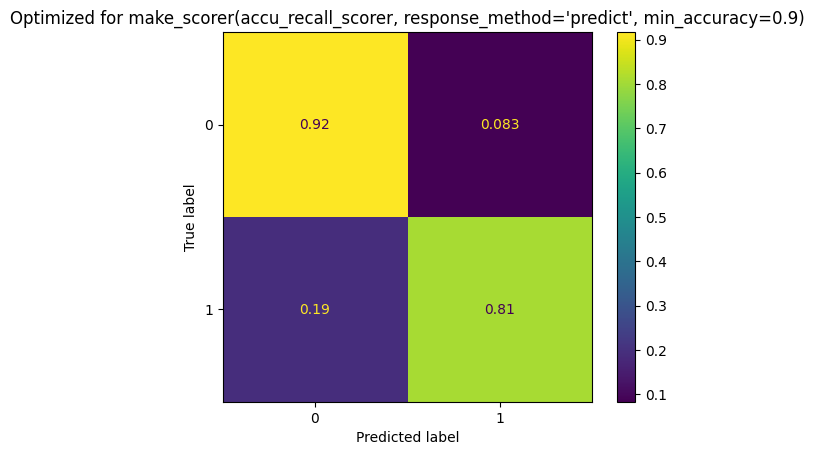

In [17]:
print_gridsearch_results(results2, X.columns)